# Import modules

In [1]:
import os
import pandas as pd
# import polars as pl
import numpy as np

# import re
# from bs4 import BeautifulSoup, SoupStrainer

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm, trange

import scipy
from scipy.sparse import csr_matrix

import copy

# Mount google drive

In [2]:
# References:
# [1] https://towardsdatascience.com/different-ways-to-connect-google-drive-to-a-google-colab-notebook-pt-1-de03433d2f7a
# [2] https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab
# [3] https://stackoverflow.com/questions/53581278/test-if-notebook-is-running-on-google-colab

try:
    from google.colab import drive
    from google.colab import files

    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:

    # mount google drive 
    drive.mount('/content/gdrive/', force_remount=True)

    import os
    #change directory
    try:
        os.chdir('/content/gdrive/MyDrive/MCED/ADC')

    except:
        os.chdir('/content/gdrive/MyDrive/ADC')

# Change working directory


In [3]:
# working directory
bdir = os.getcwd()

DF_MSTheses_dir = bdir +'/DF_MSTHESES/'
DF_MSTheses_dir

'h:\\My Drive\\MCED\\ADC/DF_MSTHESES/'

In [4]:
wdir = bdir + '/REL_DIST/' 
os.chdir(wdir)

# Auxilliary functions

In [5]:
def load_relTable(tname, wdir, dir_year):
    """
    tname - relational table name
    dir - directory where tname is stored
    rt - relational table
    df - dataframe with relational table
    """

    rt = scipy.sparse.load_npz(wdir + dir_year + '/rel_' + tname + '.npz')
    
    col0_name = tname.split('_')[0]

    row_names = pd.read_csv(wdir + '/df_Theses_' + tname.split('_')[0] + '.csv').iloc[:,0].tolist()
    col_names = pd.read_csv(wdir + '/df_Theses_' + tname.split('_')[1] + '.csv').iloc[:,0].tolist()

    df = pd.DataFrame(rt.toarray(), columns = col_names)
    df[col0_name] = row_names
    df = df [ [col0_name] + col_names]

    return df

def load_distMat(mname, wdir):
    """
    mname - relational table name
    dir - directory where mname is stored
    dir_names - diretory where df with names is stored
    distMat - distance matrix
    """

    distMat = scipy.sparse.load_npz(wdir + '/dist_' + mname + '.npz')

    col0_name = mname.split('_')[0]

    row_names = pd.read_csv(wdir + '/row_names_' + mname + '.csv').iloc[:,0].tolist()

    df = pd.DataFrame(distMat.toarray(), columns = row_names)
    df[col0_name] = row_names
    df = df [ [col0_name] + row_names]

    # creates dictionary
    for iter, row in df.iterrows():

        a = [row[0]] * (len(row) - 1)
        b = row.index.to_list()

        # https://stackoverflow.com/questions/19560044/how-to-concatenate-element-wise-two-lists-in-python
        keys = ["{} x {}".format(a_, b_) for a_, b_ in zip(a, b)]
        values = row[1:]

        dict_df = dict(zip(keys, values))

    return df, dict_df


def load_table(tname, wdir):
    """
    tname - table name
    dir - directory where tname is stored
    distMat - distance matrix
    """

    table = scipy.sparse.load_npz(wdir + '/table_' + tname + '_s.npz')

    df_names = pd.read_csv(wdir + '/df_Theses_' + tname + '.csv')

    df_base = pd.read_csv(wdir + '/df_base.csv')


    return table, df_names, df_base

def dict2dist(pair, dict_df):

    try:
        return dict_df[pair]
    except:
        return 0.0


# https://stackoverflow.com/questions/13077527/is-there-a-numpy-delete-equivalent-for-sparse-matrices
import numpy as np
from scipy.sparse import csr_matrix

def delete_from_csr(mat, row_indices=[], col_indices=[]):
    """
    Remove the rows (denoted by ``row_indices``) and columns (denoted by ``col_indices``) from the CSR sparse matrix ``mat``.
    WARNING: Indices of altered axes are reset in the returned matrix
    """
    if not isinstance(mat, csr_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")

    rows = []
    cols = []
    if row_indices:
        rows = list(row_indices)
    if col_indices:
        cols = list(col_indices)

    if len(rows) > 0 and len(cols) > 0:
        row_mask = np.ones(mat.shape[0], dtype=bool)
        row_mask[rows] = False
        col_mask = np.ones(mat.shape[1], dtype=bool)
        col_mask[cols] = False
        return mat[row_mask][:,col_mask]
    elif len(rows) > 0:
        mask = np.ones(mat.shape[0], dtype=bool)
        mask[rows] = False
        return mat[mask]
    elif len(cols) > 0:
        mask = np.ones(mat.shape[1], dtype=bool)
        mask[cols] = False
        return mat[:,mask]
    else:
        return mat


# Features table

In [6]:
feature = 'UO'
year = '2022'


# Features table
# A feature table has N rows (Theses) and M columns (features, e.g. UO, Supervisor, keyword)
# Element i,j of a feature table is 1 if feature j is presente in thesis i, 0 otherwise
#
table, df_names, df = load_table(feature, wdir)

print(table.shape)

# table[100000,:].nonzero()

df

(131181, 117)


,URL,Year,Supervisor,UO,Keywords
0,https://repositorio-aberto.up.pt/handle/10216/...,2022,[],['UPorto | FMDUP'],['Ciências médicas e da saúde']
1,https://repositorio-aberto.up.pt/handle/10216/...,2022,[],['UPorto | FEUP'],['Outras ciências da engenharia e tecnologias']
2,https://repositorio-aberto.up.pt/handle/10216/...,2022,[],['UPorto | FPCEUP'],['Ciências da educação']
3,https://repositorio-aberto.up.pt/handle/10216/...,2022,[],['UPorto | FMDUP'],['Ciências médicas e da saúde']
4,https://repositorio-aberto.up.pt/handle/10216/...,2022,[],['UPorto | FEUP'],['Outras ciências da engenharia e tecnologias']
...,...,...,...,...,...
131176,https://sapientia.ualg.pt/handle/10400.1/5948?...,2011,"['Quintas, Helena']","['UAlg | FCHS', 'UAlg | ICArEHB']","['Aprendizagem ao longo da vida', 'Educação de..."
131177,https://sapientia.ualg.pt/handle/10400.1/5964?...,2011,"['Erzini, Karim', 'Gonçalves, Jorge']","['UAlg | ICArEHB', 'UAlg | FCT']","['Densidade', 'Ecologia', 'Recursos marinhos',..."
131178,https://sapientia.ualg.pt/handle/10400.1/6736?...,2011,"['Lemos, Ida']","['UAlg | FCHS', 'UAlg | ICArEHB']","['Ansiedade', 'Imagem corporal', 'Jovens', 'Ps..."
131179,https://sapientia.ualg.pt/handle/10400.1/6872?...,2011,"['Carreira, S.']","['UAlg | ICArEHB', 'UAlg | FCT']","['Competências matemáticas', 'Conexões matemát..."


# Relational table

In [7]:
feature1 = 'UO'
feature2 = 'KW'
key = feature1 + '_' + feature2
year = '2022'

# Relational table
# A relational table has N rows (feature 1, e.g. UO, Supervisor, keyword) and M columns (feature 2, e.g. UO, Supervisor, keyword)
# Element i,j of a relational table is the number of theses which share feature i and feature j
#

df = load_relTable(key, wdir, year)

print(df.shape)

df.head()

(117, 25438)


,UO,(In)Segurança,(In)constitucionalidade,(In)sucesso,(In)sucesso escolar,(Re)construção,(Re)desenho urbano,A Volta ao Mundo,APPDA-Lisboa,AVC isquémico,...,índices de vegetação,índices hemodinâmicos,índices reprodutivos,óleo de peixe,óleos essenciais,óleos vegetais,órgãos de administração,β-amilóide,β-fosfato tricálcico,β-lactâmicos
0,UAlg | CHUA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,UAlg | CIAC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,UAlg | CIMA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,UAlg | ESEC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,UAlg | ESGHT,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Distance matrix

In [8]:
entity = 'UO'
feature = 'KW'
key = entity + '_' + feature
year = '2022'


# Distance matrix
# A distance matrix has N rows and N columns (entities, e.g. UO, Supervisor, keyword)
# Element i,j of a distance matrix represents the cosine distance between entity i and entity j, measured by the common feature
#
df, dict_df = load_distMat(key, wdir + year)

print(df.shape)

df.head()

(75, 76)


,UO,UAlg | ESEC,UAlg | ESGHT,UAlg | FCHS,UAlg | FCT,UAlg | FE,UAlg | ICArEHB,UAlg | ISE,UAveiro | DAO,UAveiro | DBio,...,UTAD | ECAV,UTAD | ECHS,UTAD | ECT,UTAD | ECVA,UTAD | ESEVR,UTL | FMH,UTL | FMV,UTL | ISA,UTL | ISCSP,UTL | ISEG
0,UAlg | ESEC,1.00000,0.000000,0.107990,0.0,0.0,0.368964,0.0,0.0,0.0,...,0.0,0.065795,0.0,0.0,0.0,0.083666,0.022628,0.0,0.024398,0.00000
1,UAlg | ESGHT,0.00000,1.000000,0.451754,0.0,0.0,0.342997,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000
2,UAlg | FCHS,0.10799,0.451754,1.000000,0.0,0.0,0.790247,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.018070,0.025658,0.0,0.018443,0.02829
3,UAlg | FCT,0.00000,0.000000,0.000000,1.0,0.0,0.108465,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000
4,UAlg | FE,0.00000,0.000000,0.000000,0.0,1.0,0.472789,0.0,0.0,0.0,...,0.0,0.039936,0.0,0.0,0.0,0.021764,0.000000,0.0,0.029617,0.00000


# Social network tables

## UO_UO

  0%|          | 0/12 [00:00<?, ?it/s]

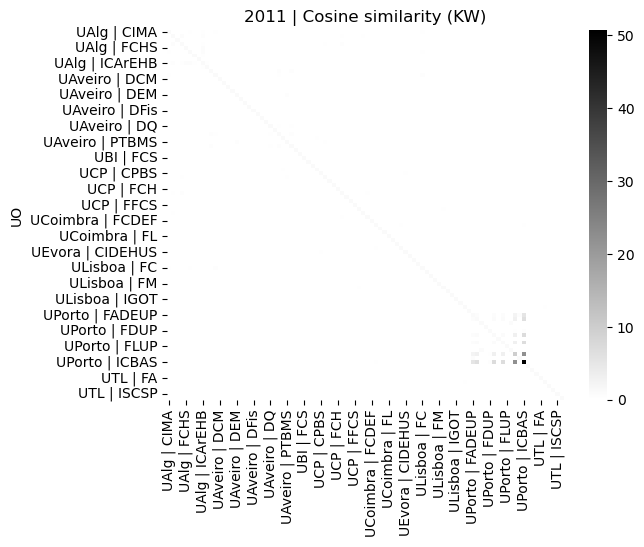

  8%|▊         | 1/12 [00:03<00:40,  3.69s/it]

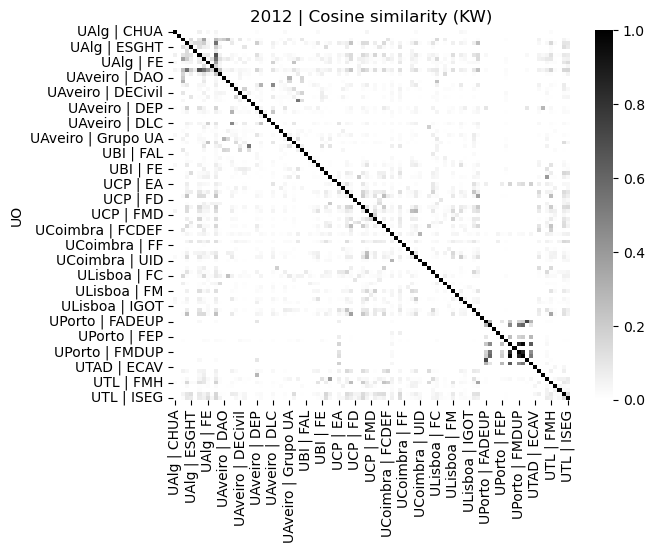

 17%|█▋        | 2/12 [00:07<00:35,  3.54s/it]

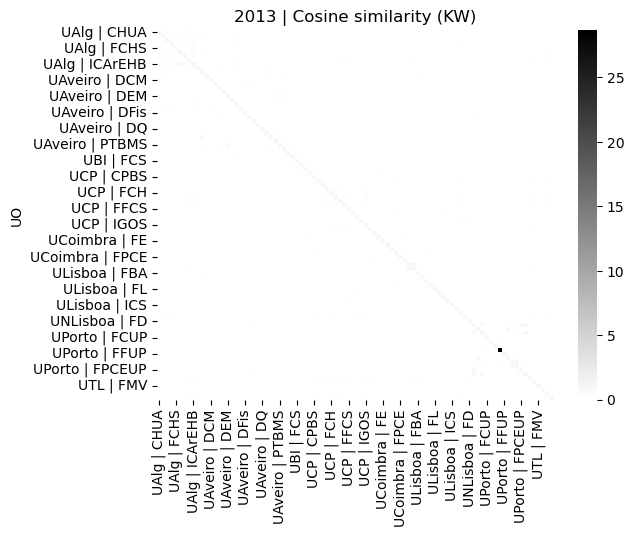

 25%|██▌       | 3/12 [00:10<00:32,  3.56s/it]

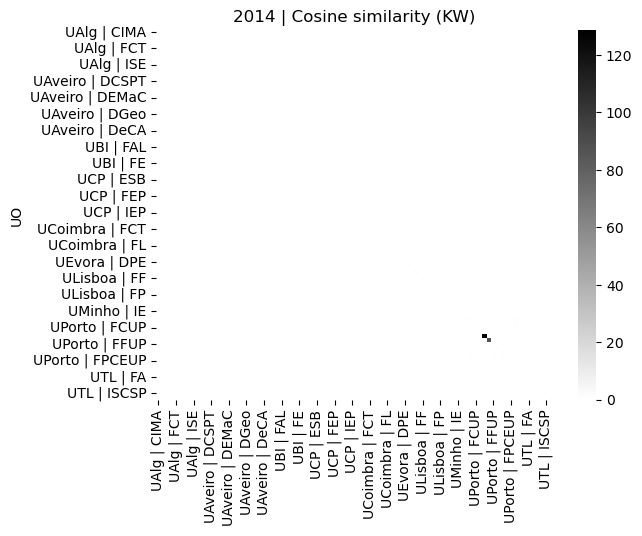

 33%|███▎      | 4/12 [00:14<00:28,  3.54s/it]

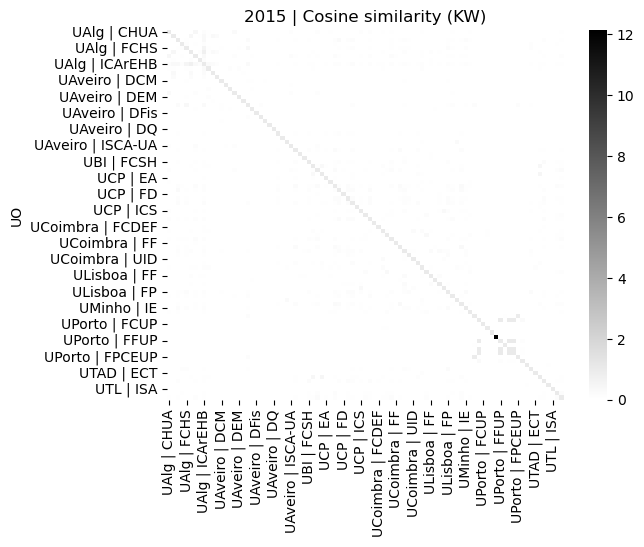

 42%|████▏     | 5/12 [00:17<00:24,  3.53s/it]

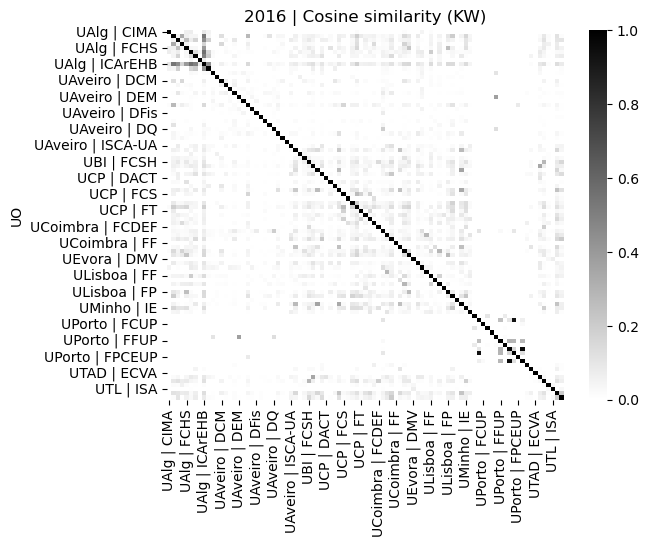

 50%|█████     | 6/12 [00:21<00:21,  3.53s/it]

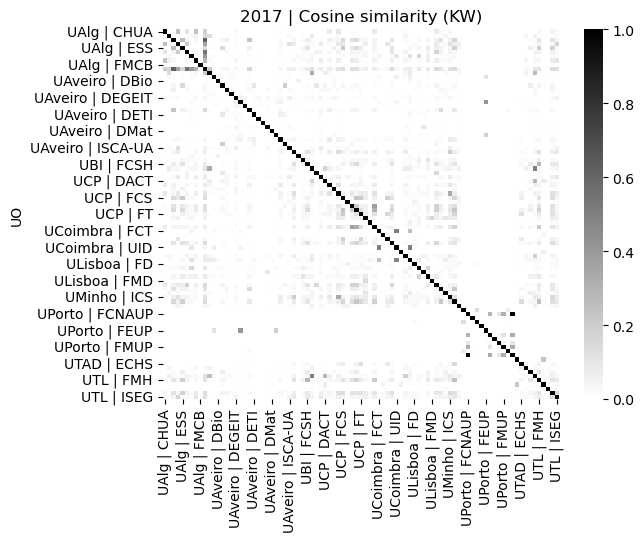

 58%|█████▊    | 7/12 [00:24<00:17,  3.49s/it]

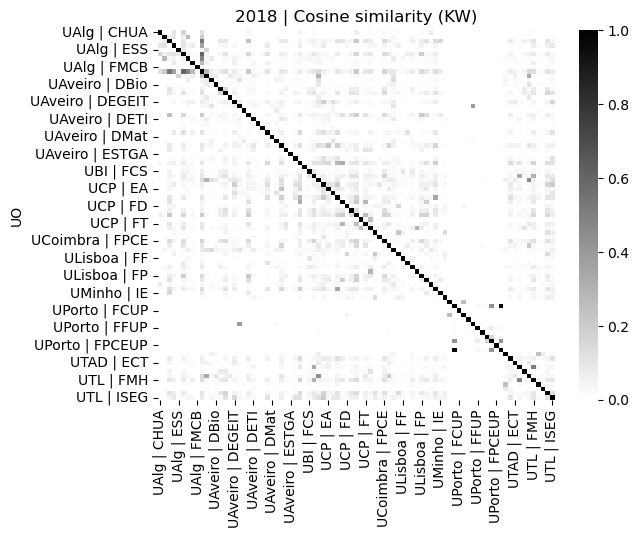

 67%|██████▋   | 8/12 [00:28<00:13,  3.50s/it]

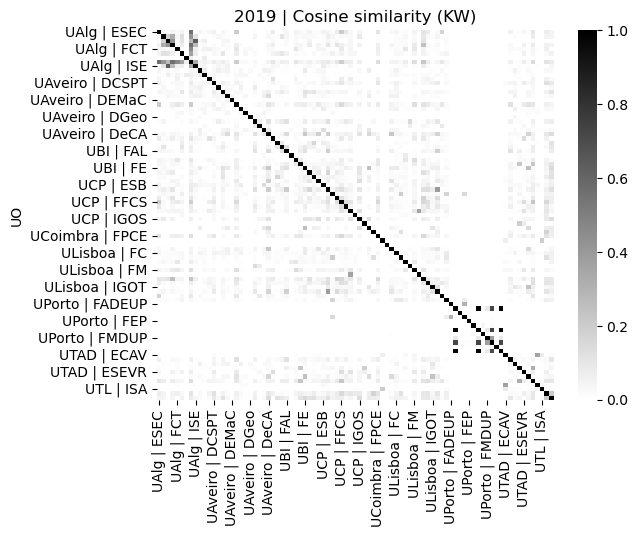

 75%|███████▌  | 9/12 [00:31<00:10,  3.54s/it]

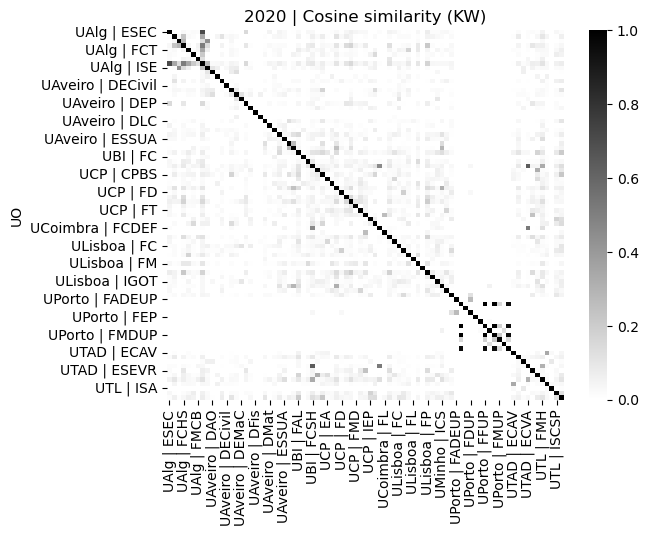

 83%|████████▎ | 10/12 [00:35<00:07,  3.59s/it]

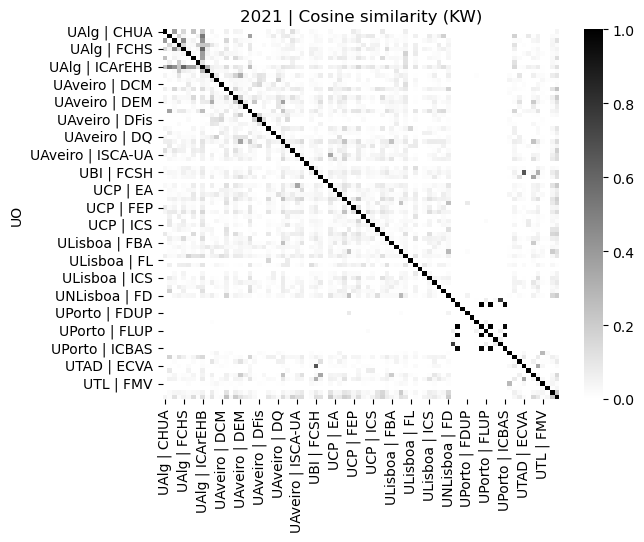

 92%|█████████▏| 11/12 [00:39<00:03,  3.60s/it]

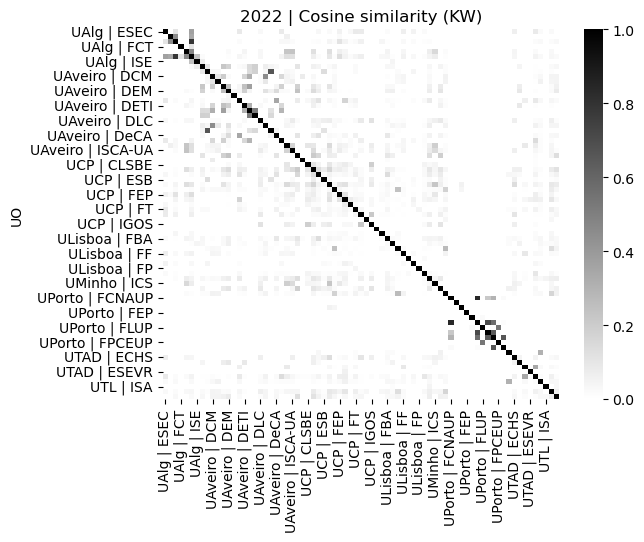

100%|██████████| 12/12 [00:42<00:00,  3.58s/it]


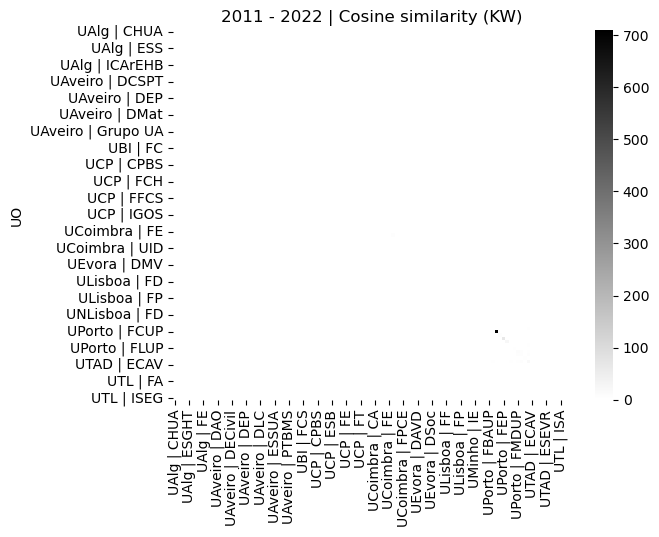

100%|██████████| 117/117 [00:01<00:00, 86.60it/s]


,Univ,Fac,UO1,UO2,UO1Theses,UO1xUO2_Theses,CosSim
0,UAlg,CHUA,UAlg | CHUA,UO,15,15,0.0
4,UAlg,CHUA,UAlg | CHUA,UAlg | ESEC,15,2,0.0
6,UAlg,CHUA,UAlg | CHUA,UAlg | ESS,15,2,0.0
8,UAlg,CHUA,UAlg | CHUA,UAlg | FCT,15,11,0.0
10,UAlg,CHUA,UAlg | CHUA,UAlg | FMCB,15,15,0.0
...,...,...,...,...,...,...,...
13334,UTL,FMV,UTL | FMV,UTL | FMH,1103,1103,0.0
13449,UTL,ISA,UTL | ISA,UTAD | ESEVR,1360,1,0.0
13452,UTL,ISA,UTL | ISA,UTL | FMV,1360,1360,0.0
13570,UTL,ISCSP,UTL | ISCSP,UTL | ISA,959,959,0.0


In [9]:
def SN_UO_UO(wdir, dir_year):
        
    # Relational table
    feature1 = 'UO'
    feature2 = 'UO'
    key = feature1 + '_' + feature2

    df_relTable = load_relTable(key, wdir, dir_year)
    # print(df_relTable.shape)

    # Distance matrix
    entity = 'UO'
    feature = 'KW'
    key = entity + '_' + feature

    df_distMat, dict_distMat = load_distMat(key, wdir + dir_year)
    # print(df_distMat.shape)


    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(255, 20, as_cmap=True)

    df = copy.deepcopy(df_distMat)
    df.index = df[entity]
    df = df.drop(entity, axis =1)

    ax = plt.axes()
    sns.heatmap(df, cmap="gray_r")
    ax.set_title(dir_year + ' | Cosine similarity (KW)')
    plt.savefig(wdir + dir_year + '/UO_UO_cossim.png')
    plt.show()



    # Features table
    feature = 'UO'
    table, df_names, df = load_table(feature, wdir)


    # Social network table
    df_SN = pd.DataFrame()

    for iter in trange(len(df_relTable.index)):

        row = df_relTable.iloc[iter]
        df = pd.DataFrame(zip(row.index, row[1:]), columns = ['UO2', 'UO1xUO2_Theses'])
        UO = df_relTable.iloc[iter]['UO']
        df['UO1'] = UO
        df['Univ'] = UO.split(' | ')[0]
        df['Fac'] = UO.split(' | ')[1]

        df['UO1Theses'] = [df_names[df_names.iloc[:,0] == UO].iloc[0]['Count']]*(len(row)-1)
        
        df['CosSim'] = ["{} x {}".format(a_, b_) for a_, b_ in zip(df['UO1'], df['UO2'])]
        df['CosSim'] = df['CosSim'].apply(lambda x: dict2dist(x, dict_distMat))

        df_SN = pd.concat([df_SN, df]).reset_index(drop = True)

    df_SN = df_SN[['Univ', 'Fac', 'UO1', 'UO2', 'UO1Theses', 'UO1xUO2_Theses', 'CosSim']]

    df_SN = df_SN[df_SN['UO1xUO2_Theses'] > 0]

    df_SN.to_csv(wdir + dir_year + '/df_SN_UO_UO.csv', index= False)

    return df_SN


for year in trange(2011,2023,1):
    
    dir_year = str(year)

    SN_UO_UO(wdir, dir_year)


dir_year = '2011 - 2022'
print(dir_year)
SN_UO_UO(wdir, dir_year)

## Pearson correlation similarity

In [10]:
# # Relational table
# feature1 = 'UO'
# feature2 = 'KW'
# key = feature1 + '_' + feature2

# mat = scipy.sparse.load_npz(wdir + dir_year + '/rel_' + key + '.npz')

# # drops rows/columns without features
# colzeros = np.where(np.squeeze(np.array(np.sum(mat, axis = 0))) == 0)[0].tolist()
# rowzeros = np.where(np.squeeze(np.array(np.sum(mat, axis = 1))) == 0)[0].tolist()
# # print(len(colzeros), len(rowzeros))

# mat = delete_from_csr(mat, row_indices = rowzeros, col_indices = colzeros)

# arr_corr = np.corrcoef(mat.toarray())

# row_names = pd.read_csv(wdir + dir_year + '/row_names_' + key + '.csv').iloc[:,0].tolist()

# df = pd.DataFrame(arr_corr, columns = row_names)
# df.index = row_names


# ax = plt.axes()

# sns.heatmap(df, cmap="gray_r")

# ax.set_title('Pearson correlation (KW)')
# plt.show()



## UO + S

In [11]:


def SN_UO_S(wdir, dir_year):

    # Relational table
    feature1 = 'UO'
    feature2 = 'S'
    key = feature1 + '_' + feature2

    df_relTable = load_relTable(key, wdir, dir_year)
    # print(df_relTable.shape)


    # Social network table
    df_SN = pd.DataFrame()

    for iter in trange(len(df_relTable.index)):

        row = df_relTable.iloc[iter]
        df = pd.DataFrame(zip(row.index[1:], row[1:]), columns = ['Supervisor', '#Theses supervised'])
        UO = df_relTable.iloc[iter]['UO']
        df['UO'] = UO
        df['Univ'] = UO.split(' | ')[0]
        df['Fac'] = UO.split(' | ')[1]

        df['UO_Theses'] = [df_names[df_names.iloc[:,0] == UO].iloc[0]['Count']]*(len(row)-1)
        
        df_SN = pd.concat([df_SN, df]).reset_index(drop = True)

    df_SN = df_SN[['Univ', 'Fac', 'UO', 'UO_Theses', 'Supervisor', '#Theses supervised']]

    df_SN = df_SN[df_SN['#Theses supervised'] > 0]
    df_SN.to_csv(wdir + dir_year + '/df_SN_UO_S.csv', index= False)
    
    return df_SN


for year in range(2011,2023,1):
    
    dir_year = str(year)
    print(dir_year)

    SN_UO_S(wdir, dir_year)


dir_year = '2011 - 2022'
print(dir_year)
SN_UO_S(wdir, dir_year)


2011


100%|██████████| 117/117 [00:59<00:00,  1.96it/s]


2012


100%|██████████| 117/117 [00:56<00:00,  2.07it/s]


2013


100%|██████████| 117/117 [00:52<00:00,  2.23it/s]


2014


100%|██████████| 117/117 [00:53<00:00,  2.19it/s]


2015


100%|██████████| 117/117 [00:53<00:00,  2.20it/s]


2016


100%|██████████| 117/117 [00:52<00:00,  2.22it/s]


2017


100%|██████████| 117/117 [00:57<00:00,  2.03it/s]


2018


100%|██████████| 117/117 [00:50<00:00,  2.30it/s]


2019


100%|██████████| 117/117 [00:52<00:00,  2.24it/s]


2020


100%|██████████| 117/117 [00:53<00:00,  2.18it/s]


2021


100%|██████████| 117/117 [00:54<00:00,  2.15it/s]


2022


100%|██████████| 117/117 [00:52<00:00,  2.23it/s]


,Univ,Fac,UO,UO_Theses,Supervisor,#Theses supervised
623,UAlg,CHUA,UAlg | CHUA,15,"Amado, Carla",1
2743,UAlg,CHUA,UAlg | CHUA,15,"Castela, Guilherme",2
3031,UAlg,CHUA,UAlg | CHUA,15,"Coelho, Luís",1
3144,UAlg,CHUA,UAlg | CHUA,15,"Contreiras, Joaquim",1
6037,UAlg,CHUA,UAlg | CHUA,15,"Gonçalves, Gabriela",2
...,...,...,...,...,...,...
1738576,UTL,ISEG,UTL | ISEG,3666,"Vieira, Pedro Nuno Rino Carreira",2
1738577,UTL,ISEG,UTL | ISEG,3666,"Vieira, Pedro Rino",15
1738586,UTL,ISEG,UTL | ISEG,3666,"Vieira, Telmo",3
1738692,UTL,ISEG,UTL | ISEG,3666,"Zacarias, Abílio",8


## UO + KW

In [12]:


def SN_UO_KW(wdir, dir_year):


    # Relational table
    feature1 = 'UO'
    feature2 = 'KW'
    key = feature1 + '_' + feature2

    df_relTable = load_relTable(key, wdir, dir_year)
    # print(df_relTable.shape)


    # Features table
    feature = 'UO'
    table, df_names, df = load_table(feature, wdir)

    # print(table.shape)


    # Social network table
    df_SN = pd.DataFrame()

    for iter in trange(len(df_relTable.index)):

        row = df_relTable.iloc[iter]
        df = pd.DataFrame(zip(row.index[1:], row[1:]), columns = ['KW', '#KW'])
        UO = df_relTable.iloc[iter]['UO']
        df['UO'] = UO
        df['Univ'] = UO.split(' | ')[0]
        df['Fac'] = UO.split(' | ')[1]

        df['UO_Theses'] = [df_names[df_names.iloc[:,0] == UO].iloc[0]['Count']]*(len(row)-1)
        
        df_SN = pd.concat([df_SN, df]).reset_index(drop = True)

    df_SN = df_SN[['Univ', 'Fac', 'UO', 'UO_Theses', 'KW', '#KW']]

    df_SN = df_SN[df_SN['#KW'] > 0]
    
    df_SN.to_csv(wdir + dir_year + '/df_SN_UO_KW.csv', index= False)
    
    return df_SN



for year in range(2011,2023,1):
    
    dir_year = str(year)
    print(dir_year)
    
    SN_UO_KW(wdir, dir_year)


dir_year = '2011 - 2022'
print(dir_year)
SN_UO_KW(wdir, dir_year)

2011


100%|██████████| 117/117 [01:32<00:00,  1.26it/s]


2012


100%|██████████| 117/117 [01:34<00:00,  1.23it/s]


2013


100%|██████████| 117/117 [01:33<00:00,  1.25it/s]


2014


100%|██████████| 117/117 [01:33<00:00,  1.25it/s]


2015


100%|██████████| 117/117 [01:31<00:00,  1.28it/s]


2016


100%|██████████| 117/117 [01:34<00:00,  1.24it/s]


2017


100%|██████████| 117/117 [01:34<00:00,  1.24it/s]


2018


100%|██████████| 117/117 [01:33<00:00,  1.26it/s]


2019


100%|██████████| 117/117 [01:32<00:00,  1.27it/s]


2020


100%|██████████| 117/117 [01:33<00:00,  1.25it/s]


2021


100%|██████████| 117/117 [01:32<00:00,  1.26it/s]


2022


100%|██████████| 117/117 [01:32<00:00,  1.26it/s]


2011 - 2022


100%|██████████| 117/117 [01:32<00:00,  1.26it/s]


,Univ,Fac,UO,UO_Theses,KW,#KW
105,UAlg,CHUA,UAlg | CHUA,15,Acesso,1
2116,UAlg,CHUA,UAlg | CHUA,15,Avaliação de desempenho,1
4728,UAlg,CHUA,UAlg | CHUA,15,Contratualização,1
5799,UAlg,CHUA,UAlg | CHUA,15,Desempenho profissional,1
7315,UAlg,CHUA,UAlg | CHUA,15,Educação a distância,1
...,...,...,...,...,...,...
2976110,UTL,ISEG,UTL | ISEG,3666,águas subterrâneas,1
2976115,UTL,ISEG,UTL | ISEG,3666,ética,3
2976116,UTL,ISEG,UTL | ISEG,3666,índice de divulgação,1
2976117,UTL,ISEG,UTL | ISEG,3666,índices,1
